In [1]:
#Import libraries & data

exec(open("../python/nb_setup.py").read())#Is there a better way to do this?

from IPython.core.display import display, HTML
from matplotlib.pyplot import *
style.use('../mplstyles/stylelib/standard.mplstyle')


from tqdm.notebook import tqdm
from scipy.optimize import fsolve
from scipy.special import erf
from scipy.interpolate import CubicSpline
import pickle as pkl
import sys
sys.path.append('../python')
import R68_yield as Yield
import R68_spec_tools as spec
import R68_plot_tools as pt
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.patches as mpatches

#Set up notebook and load some R68 constants (V, eps, etc.)
from constants import *

dict_keys(['xx', 'yy', 'ex', 'ey'])


In [2]:
#Function Definitions

#Turns out we need the helper functions to still be defined since the stored samplers rely on them.
#Don't think it matters if they're exactly the same as what was used, since we don't use them here.
def Fit_helper(theta):
    return calc_log_prob(model='Sor', theta=theta, theta_bounds=((0,1),(0,3e-2),(0,10),(0,5)),
                         spec_bounds=(5,101), likelihood='Pois')

def ERtoNR(ER,Y,V,eps):
    func = lambda NR : NR-ER*(1+V/eps)/(1+Y.calc(NR)*V/eps)
    NR_guess = ER
    return fsolve(func, NR_guess)

def NRtoER(NR,Y,V,eps):
    return NR*(1+Y.calc(NR)*V/eps)/(1+V/eps)

In [3]:
#Now run Sorensen

model_label='Sorensen'
fnames=['data/mcmc_Sor_128walk_50kstep_SNorm_v3.pkl',
        'data/mcmc_Sor_128walk_50kstep_SNorm_v4.pkl']

mcmc_datas=[]
for fname in fnames:
    with open(fname,'rb') as file:
        mcmc_datas.append(pkl.load(file))
RQss=[]
for datai in mcmc_datas:
    RQss.append(datai['RQs'])

In [4]:
ySor = lambda Er : Yield.ySor(Er,0.151,1.96e-3) 
ySorv = np.vectorize(ySor)

print(ySorv([500,501]))
print(Yield.ySor(500,0.151,1.96e-3))  #these are the parameters from the paper. 

[0.03458463 0.03495958]
0.03458463040758847


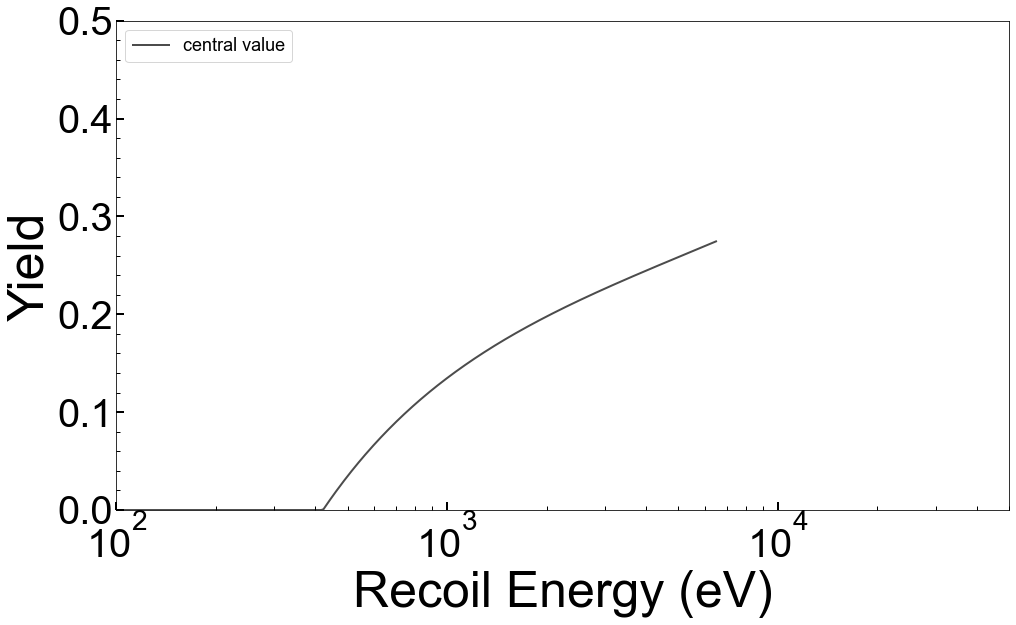

In [7]:
plt.figure(figsize=(16,9))

plot_fill_colors=['g','g']
plot_alphas=[0.7,0.3]
plot_zorders=[2,1,0]
plot_labels=['This work: Stat','Stat+Syst']#,'+BurstSyst']

vEr = np.linspace(0.0,6500,1000)
#print(ySorv(vEr))

plt.plot(vEr,ySorv(vEr),label="central value",alpha=0.7,color='k')

for i,RQi in enumerate(RQss):
    Er_Ycalc_plot=np.concatenate((RQi['Er_Ycalc'][0][:1],RQi['Er_Ycalc'][1],RQi['Er_Ycalc'][0][-1:],RQi['Er_Ycalc'][2][::-1]))
    Ydist_plot=np.concatenate((RQi['Ydist'][0][:1],RQi['Ydist'][1],RQi['Ydist'][0][-1:],RQi['Ydist'][2][::-1]))

    plt.fill(Er_Ycalc_plot,Ydist_plot,color=plot_fill_colors[i],zorder=plot_zorders[i], alpha=plot_alphas[i], label=plot_labels[i])

plt.ylabel("Yield")
plt.xlabel("Recoil Energy (eV)")
#plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
#plt.rc('ytick', labelsize=16) #fontsize of the y tick labels
plt.xlim([100,50000])
plt.ylim([0,0.5])
plt.xscale('log')

plt.legend(fontsize=18,loc='upper left')
plt.show()

